In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv('model.csv')

In [35]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,is_mail,comment_duplication,classifier_val
0,0,0.372249,0.280355,3.057751,0.083333,3,6.612096,4.0,0,0.000000,8.750086,1.0,1,0,0,0,0.000000,1
1,1,0.354255,0.341604,2.410947,0.000000,1,4.897796,1.0,0,0.000000,15.380144,2.0,0,0,0,0,0.715092,0
2,2,0.487752,0.314966,1.578192,0.000000,1,3.791178,0.0,0,0.000000,14.181022,0.0,0,0,0,0,0.000000,0
3,3,0.468095,0.368193,2.328976,0.000000,1,5.041488,0.0,0,0.090909,13.636652,2.0,0,0,0,0,0.000000,0
4,4,0.366191,0.258061,2.238987,0.000000,1,5.174158,4.0,0,0.000000,13.529500,0.0,1,1,0,0,0.000000,0


In [36]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'is_mail', 'comment_duplication', 'classifier_val'],
      dtype='object')

### Standardization

In [37]:
dfc = df.copy()

In [38]:
y = dfc['classifier_val']
X = dfc.drop(['classifier_val','id'],axis=1)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

### Handle imbalance dataset

In [41]:
dfc['classifier_val'].value_counts()

0    2540
1     585
Name: classifier_val, dtype: int64

In [42]:
from imblearn.combine import SMOTETomek
from collections import Counter

os=SMOTETomek(1)
X_train_os,y_train_os=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

X_train = X_train_os
y_train = y_train_os

C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


The number of classes before fit Counter({0: 1778, 1: 409})
The number of classes after fit Counter({1: 1765, 0: 1765})


### Hyperparameter Tuning

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [12]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [19]:
grid = {
   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [int(x) for x in range(1,70,2)],
 
    'n_neighbors': [int(x) for x in range(5,80)],
    'p': [1,2],
    'weights':['uniform', 'distance']
}

In [20]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True) 

In [21]:
from sklearn.model_selection import RandomizedSearchCV
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [43]:
knn_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.7min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21, 23, 25, 27,
                                                      29, 31, 33, 35, 37, 39,
                                                      41, 43, 45, 47, 49, 51,
                                                      53, 55, 57, 59, ...],
                                        'n_neighbors': [5, 6, 7, 8, 9, 10, 11,
                                                        12, 13, 14, 15, 16, 17,
                                                        18, 19, 20, 21, 22, 23,
                         

### Evaluvate

In [44]:
knn_random.best_score_

0.9331444759206798

In [45]:
knn_random.best_params_

{'weights': 'distance',
 'p': 1,
 'n_neighbors': 8,
 'leaf_size': 25,
 'algorithm': 'ball_tree'}

In [46]:
best_model = knn_random.best_estimator_

In [48]:
best_model

KNeighborsClassifier(algorithm='ball_tree', leaf_size=25, n_neighbors=8, p=1,
                     weights='distance')

In [49]:
y_pred = best_model.predict(X_test)

In [50]:
err = (y_pred - y_test)

<AxesSubplot:>

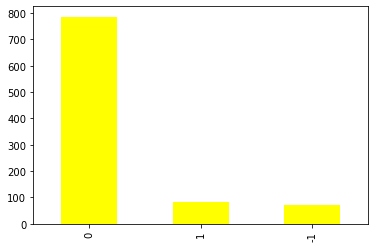

In [51]:
err.value_counts().plot(kind='bar',color='yellow')

In [52]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.16204690831556504
MSE: 0.16204690831556504
RMSE: 0.4025505040557831


In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[680  82]
 [ 70 106]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       762
           1       0.56      0.60      0.58       176

    accuracy                           0.84       938
   macro avg       0.74      0.75      0.74       938
weighted avg       0.84      0.84      0.84       938



In [31]:
# for save the model if you want
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

In [32]:
# Best score 0.9143196528569003